<a href="https://colab.research.google.com/github/woominhee/Everyones-Deep-Learning/blob/main/ch18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 18장 시퀀스 배열로 다루는 순환 신경망(RNN)

## 1. LSTM을 이용한 로이터 뉴스 카테고리 분류하기

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눈다.
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

# 데이터 확인
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [4]:
# 단어 수 맞추기
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

# 원-핫 인코딩 처리
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델 구조 설정
model = Sequential()
model.add(Embedding(1000, 100))  # 입력된 값을 받아 다음 층이 알 수 있는 형태로 변환
model.add(LSTM(100, activation='tanh'))  # RNN 에서 기억 값에 대한 가중치를 제어
model.add(Dense(46, activation='softmax'))

# 모델의 실행 옵션 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델 실행
history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/200
450/450 [==============================] - 31s 64ms/step - loss: 2.2673 - accuracy: 0.4284 - val_loss: 2.0188 - val_accuracy: 0.5009
Epoch 2/200
450/450 [==============================] - 31s 69ms/step - loss: 1.8878 - accuracy: 0.5184 - val_loss: 1.8008 - val_accuracy: 0.5410
Epoch 3/200
450/450 [==============================] - 30s 66ms/step - loss: 1.7543 - accuracy: 0.5605 - val_loss: 1.6789 - val_accuracy: 0.5672
Epoch 4/200
450/450 [==============================] - 30s 66ms/step - loss: 1.5898 - accuracy: 0.5986 - val_loss: 1.6459 - val_accuracy: 0.5908
Epoch 5/200
450/450 [==============================] - 29s 65ms/step - loss: 1.4648 - accuracy: 0.6291 - val_loss: 1.4644 - val_accuracy: 0.6411
Epoch 6/200
450/450 [==============================] - 29s 65ms/step - loss: 1.3380 - accuracy: 0.6631 - val_loss: 1.4147 - val_accuracy: 0.6492
Epoch 7/200
450/450 [==============================] - 29s 63ms/step - loss: 1.2418 - accuracy: 0.6868 - val_loss: 1.3435 - val_ac

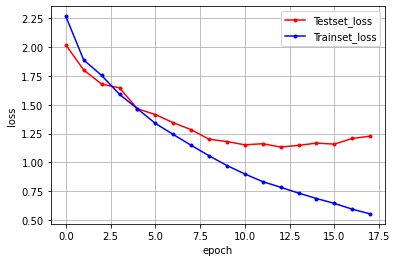

In [5]:
# 학습셋과 테스트셋의 오차 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 2. LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눈다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어 수 맞추기
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델 구조 설정
model = Sequential()
model.add(Embedding(5000, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))  # 배열 형태로 이루어진 1차웜
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

17464789/17464789 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         500000    
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 55)                26400     
                                                                 
 dense_1 (Dense)             (None, 1)                 

In [7]:
# 모델의 실행 옵션 설정
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델 실행
history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_split=0.25, callbacks=[early_stopping_callback])

# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
469/469 [==============================] - 86s 179ms/step - loss: 0.4007 - accuracy: 0.8051 - val_loss: 0.2830 - val_accuracy: 0.8798
Epoch 2/100
469/469 [==============================] - 81s 173ms/step - loss: 0.2359 - accuracy: 0.9081 - val_loss: 0.2565 - val_accuracy: 0.8950
Epoch 3/100
469/469 [==============================] - 81s 172ms/step - loss: 0.1801 - accuracy: 0.9312 - val_loss: 0.2820 - val_accuracy: 0.8859
Epoch 4/100
469/469 [==============================] - 92s 195ms/step - loss: 0.1476 - accuracy: 0.9461 - val_loss: 0.2833 - val_accuracy: 0.8914
Epoch 5/100
782/782 [==============================] - 25s 33ms/step - loss: 0.3154 - accuracy: 0.8828

 Test Accuracy: 0.8828


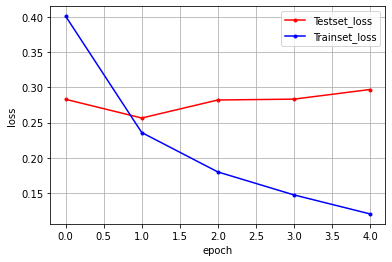

In [8]:
# 학습셋과 테스트셋의 오차 저장
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 3. 어텐션을 사용한 신경망

In [9]:
!pip install attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from attention import Attention

import numpy as np
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

model = Sequential()
model.add(Embedding(5000, 500))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Attention())
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, y_train, batch_size=40, epochs=100,  validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
625/625 [==============================] - 613s 978ms/step - loss: 0.3748 - accuracy: 0.8287 - val_loss: 0.2839 - val_accuracy: 0.8802
Epoch 2/100
625/625 [==============================] - 636s 1s/step - loss: 0.2197 - accuracy: 0.9125 - val_loss: 0.2702 - val_accuracy: 0.8884
Epoch 3/100
625/625 [==============================] - 634s 1s/step - loss: 0.1615 - accuracy: 0.9352 - val_loss: 0.2815 - val_accuracy: 0.8848
Epoch 4/100
625/625 [==============================] - 636s 1s/step - loss: 0.1155 - accuracy: 0.9561 - val_loss: 0.3393 - val_accuracy: 0.8824
Epoch 5/100
782/782 [==============================] - 118s 149ms/step - loss: 0.3814 - accuracy: 0.8740

 Test Accuracy: 0.8740


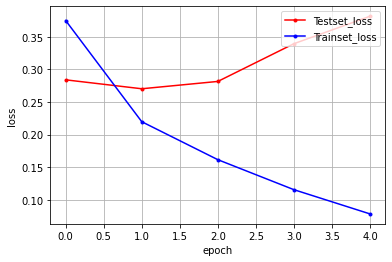

In [13]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')
 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()